In [1]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback

def zerodrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = -signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def onedrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr


# HAMILTONIAN   

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta
 
def position_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    Jvalue = args['J']
    beta = args['beta']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H01, H02, H11 = empt,  empt, empt
    
    # for i in range(N-1):
    #     id = qeye(2**i)    
    #     dim11 = N-2-i
    #     id1 = qeye(2**dim11)
    #     H01 = H01 + Qobj(tensor(id,tensor(sz,tensor(sz,id1))).full())
        
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H01 = H01 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full())\
            * j_ij(Jvalue, i,j, beta)

        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H02 = H02 + Qobj(tensor(id,tensor(sx,id1)).full()) * (1-er)
        
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H01, H02, H11


# Periodic Boundary Condition Hamiltonian
def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    Jvalue = args['J']
    #beta = args['beta']
    g = args['g']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H01, H02, H11 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H01 = H01 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())
        
    H01 = H01 + Qobj(tensor(sigmaz(), tensor(qeye(2**(N-2)), sigmaz())).full())

        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H02 = H02 + Qobj(tensor(id,tensor(sx,id1)).full()) 
        
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sz,id1)).full())

    return Jvalue * H01, g * (1-er) * H02, H11

# FLOQUET ANALYSIS

def floquet_return_position(args):
    N  =  args['N']
    er = args['er']
    H01, H02, H11 = position_hamiltonian(args)
    H = [H01,[H02, drive]]

    T = 2 * np.pi/args['omega']
    f_modes_0, f_energies = floquet_modes(H, T, args)
    return f_energies

# MAGNETIZATION
def magnetization_position(args):      
    N  =  args['N']
    H01, H02, H11 = pbc_hamiltonian(args)
    H = [[H01, onedrive], [H02, zerodrive]]

    grket = basis(2**N,0)
    times = args['times']
    data = mesolve(H, grket, times, [], [H11/N], args = args)
    return data.expect

def magnetization_stroboscopic(args):      
    N  =  args['N']
    maxT = args['maxT']
    w = args['omega']
    T = 2 * np.pi/w
    times = np.arange(0, maxT + 1) * T
    
    H01, H02, H11 = pbc_hamiltonian(args)
    H = [[H01, onedrive], [H02, zerodrive]]

    grket = basis(2**N,0)
    data = mesolve(H, grket, times, [], [H11/N], args = args)
    return data.expect

print("Functions defined")


Functions defined


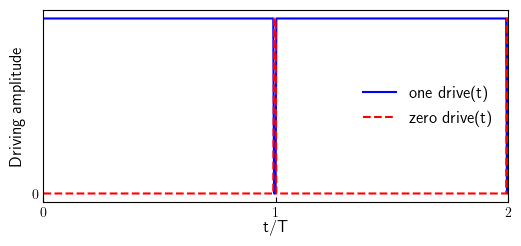

In [2]:
from scipy import signal
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (6, 2.5), "text.usetex": True, "font.size": 20})

w = 20
T = 2 * np.pi/w
times = np.linspace(0, 2*T, 600)
duty = 0.99

J = 1
g = w/2

params = {'omega': w, 'J': J , 'g': g, 'duty': duty} 

plt.plot(times/T, np.array([onedrive(t, params) for t in times]), color = 'blue', label = r'one drive(t)')

plt.plot(times/T, np.array([zerodrive(t, params) for t in times]), color = 'red', ls = '--', label = r'zero drive(t)')

plt.tick_params(axis='both', which='both', labelsize=10)
plt.xlabel('t/T', fontsize = 12, labelpad=0)
plt.ylabel(r'Driving amplitude', fontsize = 12, labelpad=5)
plt.tick_params(which='both', direction='in')
plt.xticks([0,1,2])
plt.yticks([0])
plt.legend(frameon = False,  fontsize =12, ncol =1, loc = 'best')
#plt.yticks([])
plt.xlim(0,2)
#plt.savefig("continuous_flip_drive.pdf", bbox_inches = 'tight')

plt.show()


## DTC without Rotational Error

In [3]:
%%time

import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool
#from collura_funcs import *

Ns = [8, 10, 11, 12]
omega = 10
w = omega
duty = 0.8

T = 2 * np.pi/omega
time_period = 200
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

J = 1
g = w/(4*(1-duty))
er = 0.1

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e12, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'N':N,'J':J, 'g':g, 'maxT':time_period,\
    'times':times, 'omega':w, 'opts':opts, 'duty': duty} for N in Ns]

data_strob = np.array(p.map(magnetization_stroboscopic, params))
#data_mag = np.array(p.map(magnetization_position, params))


CPU times: user 7.65 ms, sys: 37.2 ms, total: 44.8 ms
Wall time: 15.5 s


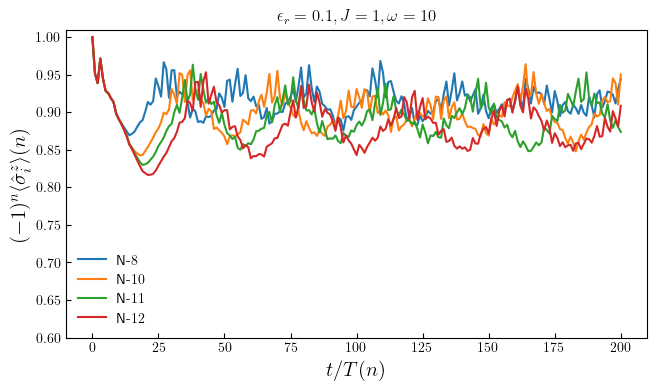

In [5]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})


order_param = [(-1)**i for i in np.arange(0, time_period + 1)]

times = np.arange(0, time_period + 1) * T
T = 2 * np.pi/omega

for i, N in enumerate(Ns):
    plt.plot(times/T, order_param * data_strob[i][0], label =fr"N-${N}$")

plt.xlabel('$t/T(n)$')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\epsilon_r={er}, J={J}, \omega={omega}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = False,  fontsize =10, loc = 'best')
#plt.xlim(0, 15)
plt.ylim(0.6, 1.01)

#plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
#plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

#for i in np.arange(0, int(times[-1]/T)+1, 2):
    #plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

plt.savefig(fr"Collura_orderParam_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()


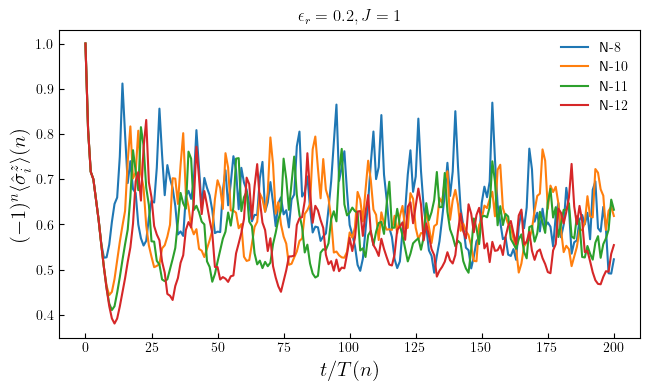

In [9]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})


order_param = [(-1)**i for i in np.arange(0, time_period + 1)]

times = np.arange(0, time_period + 1) * T
T = 2 * np.pi/omega

for i, N in enumerate(Ns):
    plt.plot(times/T, order_param * data_strob[i][0], label =fr"N-${N}$")

plt.xlabel('$t/T(n)$')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\epsilon_r={er}, J={J}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = False,  fontsize =10, loc = 'best')
#plt.xlim(0, 15)
#plt.ylim(0.6, 1.01)

#plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
#plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

#for i in np.arange(0, int(times[-1]/T)+1, 2):
    #plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

#plt.savefig(fr"Collura_orderParam_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()


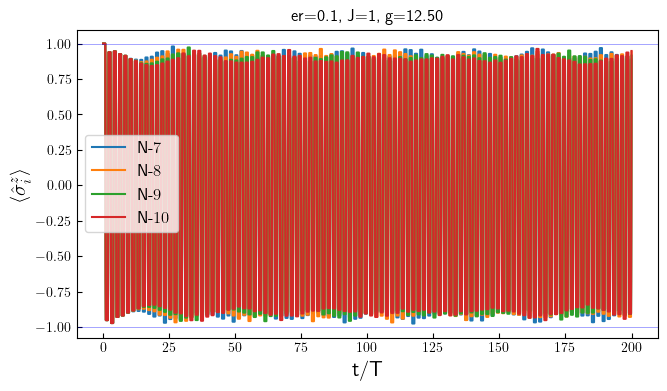

In [6]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})



T = 2 * np.pi/omega
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)


for i, N in enumerate(Ns):
    plt.plot(times/T, data_mag[i][0], label =fr"N-${N}$")

plt.xlabel('t/T')
plt.ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
plt.title(fr"er={er}, J={J}, g={g:2.2f}", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =12)
#plt.xlim(0, 15)
#plt.ylim(0.6, 1.01)

plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

#for i in np.arange(0, int(times[-1]/T)+1, 2):
#    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)
#plt.savefig(fr"mag_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()


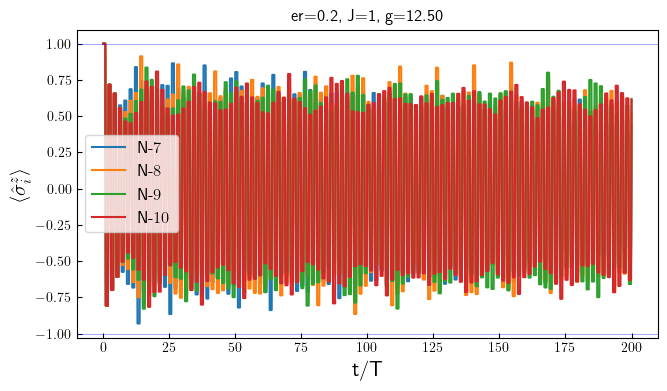

In [14]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})



T = 2 * np.pi/omega
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)


for i, N in enumerate(Ns):
    plt.plot(times/T, data_mag[i][0], label =fr"N-${N}$")

plt.xlabel('t/T')
plt.ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
plt.title(fr"er={er}, J={J}, g={g:2.2f}", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =12)
#plt.xlim(0, 15)
#plt.ylim(0.6, 1.01)

plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

#for i in np.arange(0, int(times[-1]/T)+1, 2):
#    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)
#plt.savefig(fr"mag_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()


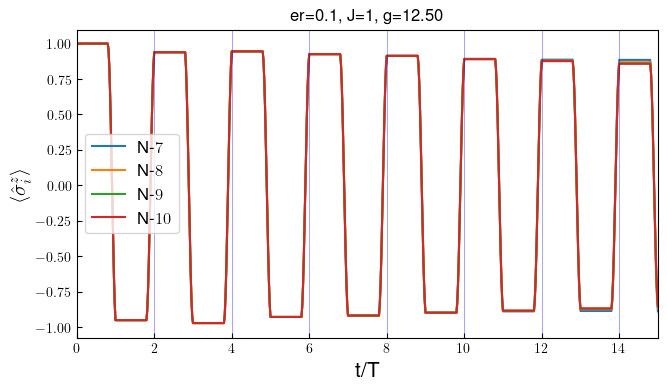

In [111]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})

T = 2 * np.pi/omega

for i, N in enumerate(Ns):
    plt.plot(times/T, data_mag[i][0], label =fr"N-${N}$")

plt.xlabel('t/T')
plt.ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
plt.title(fr"er={er}, J={J}, g={g:2.2f}", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =12)
plt.xlim(0, 15)
#plt.ylim(0.6, 1.01)

#plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
#plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

for i in np.arange(0, int(times[-1]/T)+1, 2):
    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

#plt.savefig(fr"mag_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()


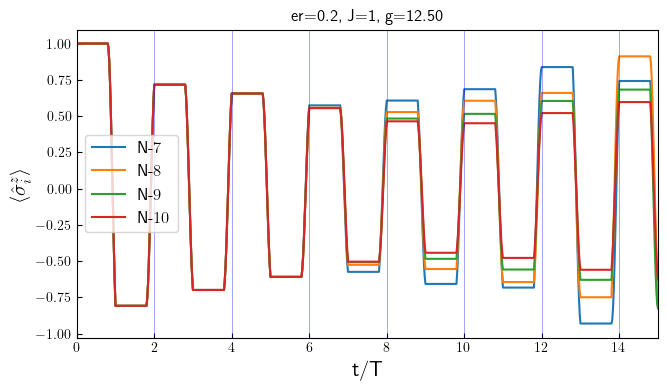

In [15]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})

T = 2 * np.pi/omega

for i, N in enumerate(Ns):
    plt.plot(times/T, data_mag[i][0], label =fr"N-${N}$")

plt.xlabel('t/T')
plt.ylabel(r'$\langle \hat{\sigma}^z_i \rangle$')
plt.title(fr"er={er}, J={J}, g={g:2.2f}", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =12)
plt.xlim(0, 15)
#plt.ylim(0.6, 1.01)

#plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
#plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

for i in np.arange(0, int(times[-1]/T)+1, 2):
    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

#plt.savefig(fr"mag_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()


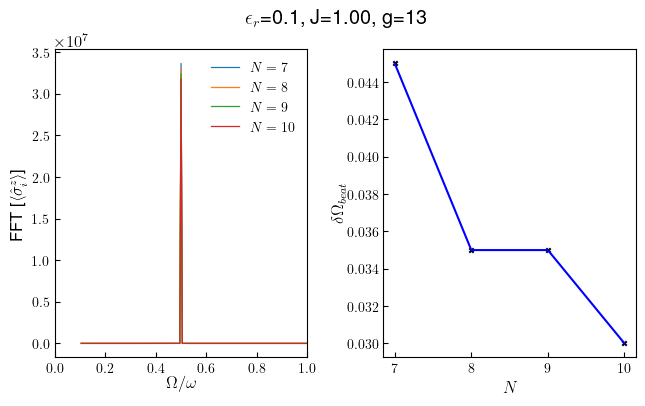

In [120]:
# Find out beats from drive functions for each N from data_tfim_p_fb datafile


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})

fig, axs = plt.subplots(1,2)
plt.subplots_adjust(hspace=0.0, wspace=0.3)

#-------  FFT   ----------------------------------------------------------------       
freq_threshold = 0.1
btfr, ers = [], [] 


for i, N in enumerate(Ns):
    #mz = data_strob[i][0]
    mz = data_mag[i][0]

   
    frequencies = T * np.fft.fftfreq(mz.size, d = times[-1]/len(times))
    fft_values = np.fft.fft(mz - np.average(mz))
    
    #mask = frequencies > freq_threshold
    mask = (frequencies > freq_threshold) & (frequencies <1.0)
    y = np.abs(fft_values[mask])**2
    x = frequencies[mask]

    line, = axs[0].plot(x, y, linewidth=0.9, label = fr'$N={N}$')           

    #-------  Find FFT Peaks and Beats frequencies   --------------------------
    
    #peak_idx, peak_props = find_peaks(y, prominence = 5, distance = None, height = 1.0e10)
    peak_idx, peak_props = find_peaks(y, prominence = 1)
    peak_pos = x[peak_idx]                     

    # Plot stars at the peaks
    #axs[0].plot(peak_pos, y[peak_idx], 'x', markersize=10, label='Peaks' if i == 0 else "")
    
    peaks_before = peak_pos[peak_pos <= 0.5]
    before_proms = peak_props['prominences'][peak_pos <= 0.5]
    if before_proms.size > 0:
        most_prominent_idx = np.argmax(before_proms)
        prominent_freq_before = peaks_before[most_prominent_idx]
    else:
        prominent_freq_before = np.nan  # or continue, or set to 0

    peaks_after = peak_pos[peak_pos >= 0.5]
    after_proms = peak_props['prominences'][peak_pos >= 0.5]
    if after_proms.size > 0:
        most_prominent_idx = np.argmax(after_proms)
        prominent_freq_after = peaks_after[most_prominent_idx]
    else:
        prominent_freq_after = np.nan  # or continue, or set to 0

    if not np.isnan(prominent_freq_before) and not np.isnan(prominent_freq_after):
        beat_freq = np.abs(prominent_freq_after - prominent_freq_before)
        btfr.append(beat_freq)
    else:
        btfr.append(np.nan)

axs[1].plot(Ns, btfr, color = 'blue')
axs[1].scatter(Ns, btfr, s = 10, marker = 'x', color = 'black')

axs[1].set_xlabel(r'$N$')
axs[1].set_ylabel(r'$\delta\Omega_{beat}$', labelpad = 0)
axs[1].set_xticks(Ns)
#axs[1].set_yscale('log')
axs[1].legend(frameon = False, fontsize = 10)
axs[1].tick_params(axis='both', which='both', labelsize=10)
axs[1].tick_params(which='both', direction='in')

axs[0].set_xlabel(r'$\Omega/\omega$', labelpad = 0)
axs[0].set_ylabel(r'FFT [$\langle \hat{\sigma}^z_i \rangle$]')
axs[0].set_xlim(0, 1)
#axs[0].set_xlim(0.48, 0.52)
#axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='both', labelsize=10)
axs[0].tick_params(which='both', direction='in')
axs[0].legend(frameon = False, fontsize = 10)
#axs[0].set_title(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")
plt.suptitle(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")

#plt.savefig(fr"DTC_mag_fft_beat_er={er}_J={J}_g={g}.pdf", bbox_inches='tight')

plt.show()

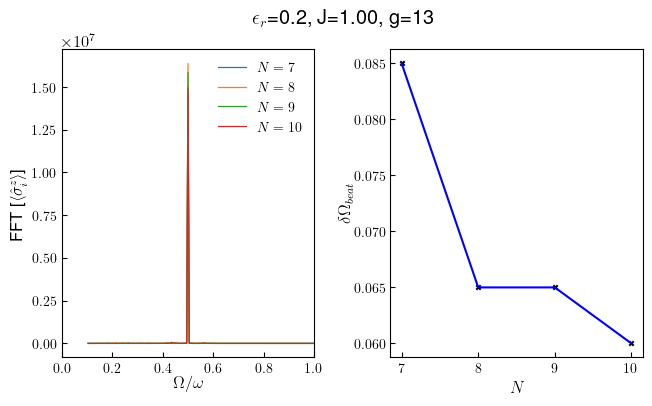

In [16]:
# Find out beats from drive functions for each N from data_tfim_p_fb datafile


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks

plt.rcParams.update({"figure.figsize": (7.5,4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})

fig, axs = plt.subplots(1,2)
plt.subplots_adjust(hspace=0.0, wspace=0.3)

#-------  FFT   ----------------------------------------------------------------       
freq_threshold = 0.1
btfr, ers = [], [] 


for i, N in enumerate(Ns):
    #mz = data_strob[i][0]
    mz = data_mag[i][0]

   
    frequencies = T * np.fft.fftfreq(mz.size, d = times[-1]/len(times))
    fft_values = np.fft.fft(mz - np.average(mz))
    
    #mask = frequencies > freq_threshold
    mask = (frequencies > freq_threshold) & (frequencies <1.0)
    y = np.abs(fft_values[mask])**2
    x = frequencies[mask]

    line, = axs[0].plot(x, y, linewidth=0.9, label = fr'$N={N}$')           

    #-------  Find FFT Peaks and Beats frequencies   --------------------------
    
    #peak_idx, peak_props = find_peaks(y, prominence = 5, distance = None, height = 1.0e10)
    peak_idx, peak_props = find_peaks(y, prominence = 1)
    peak_pos = x[peak_idx]                     

    # Plot stars at the peaks
    #axs[0].plot(peak_pos, y[peak_idx], 'x', markersize=10, label='Peaks' if i == 0 else "")
    
    peaks_before = peak_pos[peak_pos <= 0.5]
    before_proms = peak_props['prominences'][peak_pos <= 0.5]
    if before_proms.size > 0:
        most_prominent_idx = np.argmax(before_proms)
        prominent_freq_before = peaks_before[most_prominent_idx]
    else:
        prominent_freq_before = np.nan  # or continue, or set to 0

    peaks_after = peak_pos[peak_pos >= 0.5]
    after_proms = peak_props['prominences'][peak_pos >= 0.5]
    if after_proms.size > 0:
        most_prominent_idx = np.argmax(after_proms)
        prominent_freq_after = peaks_after[most_prominent_idx]
    else:
        prominent_freq_after = np.nan  # or continue, or set to 0

    if not np.isnan(prominent_freq_before) and not np.isnan(prominent_freq_after):
        beat_freq = np.abs(prominent_freq_after - prominent_freq_before)
        btfr.append(beat_freq)
    else:
        btfr.append(np.nan)

axs[1].plot(Ns, btfr, color = 'blue')
axs[1].scatter(Ns, btfr, s = 10, marker = 'x', color = 'black')

axs[1].set_xlabel(r'$N$')
axs[1].set_ylabel(r'$\delta\Omega_{beat}$', labelpad = 0)
axs[1].set_xticks(Ns)
#axs[1].set_yscale('log')
axs[1].legend(frameon = False, fontsize = 10)
axs[1].tick_params(axis='both', which='both', labelsize=10)
axs[1].tick_params(which='both', direction='in')

axs[0].set_xlabel(r'$\Omega/\omega$', labelpad = 0)
axs[0].set_ylabel(r'FFT [$\langle \hat{\sigma}^z_i \rangle$]')
axs[0].set_xlim(0, 1)
#axs[0].set_xlim(0.48, 0.52)
#axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='both', labelsize=10)
axs[0].tick_params(which='both', direction='in')
axs[0].legend(frameon = False, fontsize = 10)
#axs[0].set_title(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")
plt.suptitle(fr"$\epsilon_r$={er}, J={J:1.2f}, g={g:2.0f}")

#plt.savefig(fr"DTC_mag_fft_beat_er={er}_J={J}_g={g}.pdf", bbox_inches='tight')

plt.show()

## Now introduce DTC with the domain wall confinement

In [ ]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback

def zerodrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = -signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def onedrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def pulse_func_zz(t, args):
    t_kick_zz = args['t_kick_zz']
    T = args['T']
    t_mod = t % T  # Time within the current period
    if 0.0 <= t_mod <= t_kick_zz:
        return 1.0  # Kick is ON
    else:
        return 0.0  # Kick is OFF

def pulse_func_x(t, args):
    t_kick_x = args['t_kick_x']
    t_kick_zz = args['t_kick_zz']
    t_wait_1 = args['t_wait_1']
    T = args['T']
    t_mod = t % T  # Time within the current period
    t_start = t_kick_zz + t_wait_1
    t_end = t_start + t_kick_x
    
    if t_start < t_mod <= t_end:
        return 1.0  # Kick is ON
    else:
        return 0.0  # Kick is OFF

def pulse_func_z(t, args):
    t_kick_z = args['t_kick_z']
    t_kick_x = args['t_kick_x']
    t_kick_zz = args['t_kick_zz']
    t_wait_2 = args['t_wait_2']
    T = args['T']
    t_mod = t % T  # Time within the current period
    t_start = t_kick_zz + t_kick_x + t_wait_2
    t_end = t_start + t_kick_z
    
    if t_start < t_mod <= t_end:
        return 1.0  # Kick is ON
    else:
        return 0.0  # Kick is OFF


# HAMILTONIAN   
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta
 
def position_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    Jvalue = args['J']
    beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
    
    for i in range(N-1):
         id = qeye(2**i)    
         dim11 = N-2-i
         id1 = qeye(2**dim11)
         H1 = H1 + Qobj(tensor(id,tensor(sz,tensor(sz,id1))).full())
    ''' 
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full())\
            * j_ij(Jvalue, i,j, beta)
    '''  
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full())        
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())
        
    H01 = - Jvalue * H1    
    H11  = -h * H3
    H02 = - (g + er) * H2

    return H01, H11, H02, H3


# Periodic Boundary Condition Hamiltonian
def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + J * Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - H1/N    
    H11  = - (H2 * er + h * H3)
    H02 = - g * H2 

    return H01, H11, H02, H3

# MAGNETIZATION
def magnetization_stroboscopic(args):      
    N  =  args['N']
    maxT = args['maxT']
    w = args['omega']
    T = 2 * np.pi/w
    times = np.arange(0, maxT + 1) * T

    H01, H11, H02, H3 = pbc_hamiltonian(args)
    #H = [[H01, pulse_func_zz], [H11, pulse_func_x], [H02, pulse_func_z]]
    H = [[H01, pulse_func_zz], [H11, pulse_func_z], [H02, pulse_func_z]]

    grket = basis(2**N,0)
    data = mesolve(H, grket, times, [], [H3/N], args = args)
    return data.expect

print("Functions defined")


Functions defined


In [5]:
%%time
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool
#from collura_funcs import *

Ns = [8, 9, 10]
omega = 20
w = omega
T = 2 * np.pi/omega
beta = float('inf')

kick_duty = 0.5

# Define pulse durations within the period T
t_kick_zz = T * kick_duty     # X-kick duration
t_kick_x = T * 0    # X-kick duration
t_kick_z = T * (1- kick_duty)    # Z-kick duration
t_wait_1 = 0     # Wait time after X-kick
t_wait_2 = 0      # Wait time after Z-kick

time_period = 100
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

J = 1
g = w/(4*(1-kick_duty))
er = 0.1
h  = 0.0

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'N':N,'J':J, 'g':g, 'maxT':time_period,\
    'times':times, 'omega':w, 'opts':opts,'beta':beta,\
        't_kick_zz': t_kick_zz, 't_kick_x': t_kick_x,'h':h,\
        't_kick_z': t_kick_z, 't_wait_1': t_wait_1, 't_wait_2': t_wait_2, 'T': T} for N in Ns]

data_strob = np.array(p.map(magnetization_stroboscopic, params))
#data_mag = np.array(p.map(magnetization_position, params))



CPU times: user 6.18 ms, sys: 21.8 ms, total: 28 ms
Wall time: 1.52 s


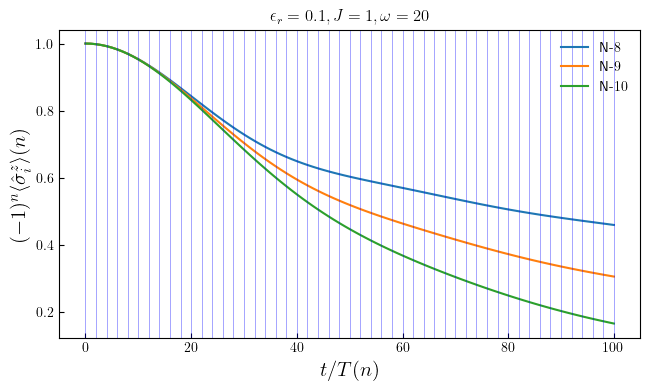

In [6]:
plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})


order_param = [(-1)**(i) for i in np.arange(0, time_period + 1)]
strob_times = np.arange(0, time_period + 1) * T

for i, N in enumerate(Ns):
    plt.plot(strob_times/T, order_param * data_strob[i][0], label =fr"N-${N}$")

plt.xlabel('$t/T(n)$')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\epsilon_r={er}, J={J}, \omega={omega}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = False,  fontsize =10, loc = 'best')

#plt.yscale('log')
#plt.ylim(-1.1, 1.1)

#plt.xlim(20,50)

#plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
#plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

for i in np.arange(0, int(times[-1]/T)+1, 2):
    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

plt.savefig(fr"Collura_orderParam_er{er}_J{J}_g{g}.pdf", bbox_inches = 'tight')

plt.show()

Now introduce the domain wall initial state and see if DTC order persists without rotational error.

Functions defined


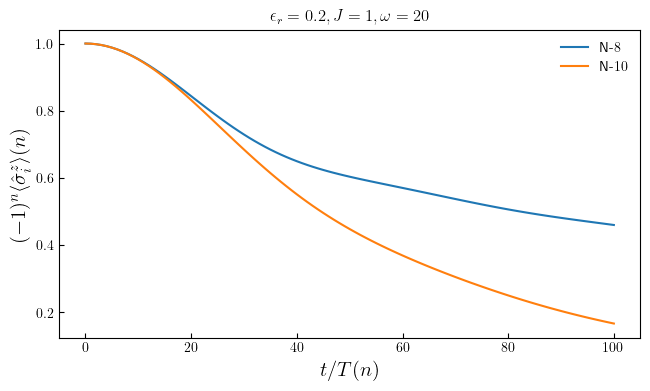

In [21]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback

def pulse_func_zz(t, args):
    t_kick_zz = args['t_kick_zz']
    T = args['T']
    t_mod = t % T  # Time within the current period
    if 0.0 <= t_mod <= t_kick_zz:
        return 1.0  # Kick is ON
    else:
        return 0.0  # Kick is OFF

def pulse_func_x(t, args):
    t_kick_x = args['t_kick_x']
    t_kick_zz = args['t_kick_zz']
    t_wait_1 = args['t_wait_1']
    T = args['T']
    t_mod = t % T  # Time within the current period
    t_start = t_kick_zz + t_wait_1
    t_end = t_start + t_kick_x
    
    if t_start < t_mod <= t_end:
        return 1.0  # Kick is ON
    else:
        return 0.0  # Kick is OFF

def pulse_func_z(t, args):
    t_kick_z = args['t_kick_z']
    t_kick_x = args['t_kick_x']
    t_kick_zz = args['t_kick_zz']
    t_wait_1 = args['t_wait_1']
    t_wait_2 = args['t_wait_2']
    T = args['T']
    t_mod = t % T  # Time within the current period
    t_start = t_kick_zz + t_wait_1 + t_kick_x + t_wait_2
    t_end = t_start + t_kick_z
    
    if t_start < t_mod <= t_end:
        return 1.0  # Kick is ON
    else:
        return 0.0  # Kick is OFF

# Periodic Boundary Condition Hamiltonian
def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + J * Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - H1/N    
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2 

    return H01, H11, H02, H3

# MAGNETIZATION
def magnetization_stroboscopic(args):      
    N  =  args['N']
    maxT = args['maxT']
    w = args['omega']
    T = 2 * np.pi/w
    times = np.arange(0, maxT + 1) * T

    H01, H11, H02, H3 = pbc_hamiltonian(args)
    H = [[H01, pulse_func_zz], [H11, pulse_func_x], [H02, pulse_func_z]]

    grket = basis(2**N,0)
    data = mesolve(H, grket, times, [], [H3/N], args = args)
    return data.expect

print("Functions defined")


import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool

Ns = [8, 10]
omega = 20
w = omega
T = 2 * np.pi/omega
beta = float('inf')

kick_duty = 0.5

# Define pulse durations within the period T
t_kick_zz = T * kick_duty     # X-kick duration
t_kick_x = T * (1- kick_duty) /2     # X-kick duration
t_kick_z = T * (1- kick_duty) /2     # Z-kick duration
t_wait_1 = 0     # Wait time after X-kick
t_wait_2 = 0      # Wait time after Z-kick

time_period = 100
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

J = 1
g = w/(4*(1- kick_duty)/2)
er = 0.2
h  = 0.8

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'N':N,'J':J, 'g':g, 'maxT':time_period,\
    'times':times, 'omega':w, 'opts':opts,'beta':beta,\
        't_kick_zz': t_kick_zz, 't_kick_x': t_kick_x,'h':h,\
        't_kick_z': t_kick_z, 't_wait_1': t_wait_1, 't_wait_2': t_wait_2, 'T': T} for N in Ns]

data_strob = np.array(p.map(magnetization_stroboscopic, params))

plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 15})


order_param = [(-1)**(i) for i in np.arange(0, time_period + 1)]
strob_times = np.arange(0, time_period + 1) * T

for i, N in enumerate(Ns):
    plt.plot(strob_times/T, order_param * data_strob[i][0], label =fr"N-${N}$")

plt.xlabel('$t/T(n)$')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\epsilon_r={er}, J={J}, \omega={omega}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = False,  fontsize =10, loc = 'best')

#plt.yscale('log')
#plt.ylim(-1.1, 1.1)

#plt.xlim(20,50)

#plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
#plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

#for i in np.arange(0, int(times[-1]/T)+1, 2):
    #plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

plt.show()



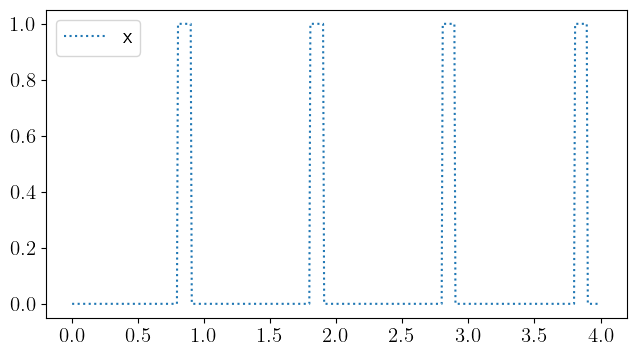

In [30]:
# Time span for simulation (e.g., 5 full periods)

omega = 20
w = omega
T = 2 * np.pi/omega

total_time = 4 * T
times = np.linspace(0, total_time, 500)


# Define pulse durations within the period T
t_kick_zz = T * 0.8      # X-kick duration
t_kick_x = T * 0.1      # X-kick duration
t_kick_z = T * 0.1      # Z-kick duration
t_wait_1 = 0     # Wait time after X-kick
t_wait_2 = 0      # Wait time after Z-kick
args = 1
# Total period T = t_kick_x + t_wait_1 + t_kick_z + t_wait_2 (T/4 * 4 = T)

zzz = [pulse_func_zz(t,params[0]) for  t in times]
xx = [pulse_func_x(t, params[0]) for  t in times]
zz = [pulse_func_z(t, params[0]) for  t in times]

#plt.plot(times/T, zzz, label = 'zz', ls = '--')
plt.plot(times/T, xx, label = 'x', ls = 'dotted')
#plt.plot(times/T, zz, label = 'z', ls = '--')

plt.legend()
plt.show()

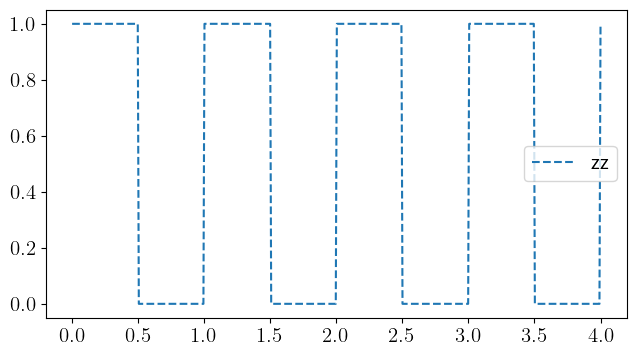

In [34]:
# Time span for simulation (e.g., 5 full periods)

omega = 20
w = omega
T = 2 * np.pi/omega

total_time = 4 * T
times = np.linspace(0, total_time, 500)


# Define pulse durations within the period T
t_kick_zz = T * (1- 0.5)     # X-kick duration
t_kick_x = T * 0     # X-kick duration
t_kick_z = T * 0.5     # Z-kick duration
t_wait_1 = 0     # Wait time after X-kick
t_wait_2 = 0      # Wait time after Z-kick
args = 1
# Total period T = t_kick_x + t_wait_1 + t_kick_z + t_wait_2 (T/4 * 4 = T)

zzz = [pulse_func_zz(t,params[0]) for  t in times]
xx = [pulse_func_x(t, params[0]) for  t in times]
zz = [pulse_func_z(t, params[0]) for  t in times]

plt.plot(times/T, zzz, label = 'zz', ls = '--')
#plt.plot(times/T, xx, label = 'x', ls = 'dotted')
#plt.plot(times/T, zz, label = 'z', ls = '--')

plt.legend()
plt.show()

In [ ]:
# Define pulse durations within the period T
t_kick_zz = T * (1- 0.5)     # X-kick duration
t_kick_x = T * 0     # X-kick duration
t_kick_z = T * 0.5     # Z-kick duration
t_wait_1 = 0     # Wait time after X-kick
t_wait_2 = 0      # Wait time after Z-kick

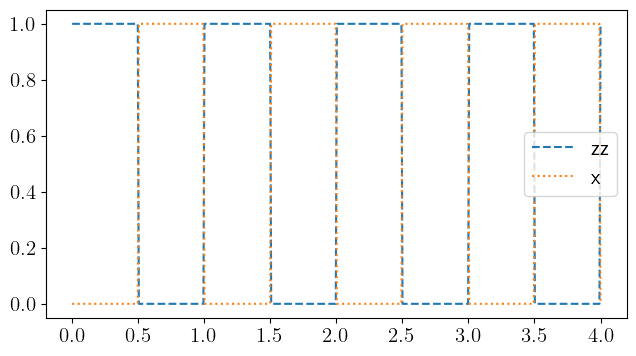

In [19]:
# Time span for simulation (e.g., 5 full periods)

from sympy import beta


omega = 20
w = omega
T = 2 * np.pi/omega

duty = 0.5

total_time = 4 * T
times = np.linspace(0, total_time, 500)

params = {'omega':omega,'er':er, 'N':N,'J':Jvalue, 'g':g, 'maxT':time_period,\
    'times':times, 'omega':w, 'opts':opts,'beta':beta,'duty':duty,\
        't_kick_zz': t_kick_zz, 't_kick_x': t_kick_x,'h':h,\
        't_kick_z': t_kick_z, 't_wait_1': t_wait_1, 't_wait_2': t_wait_2, 'T': T} 


# Define pulse durations within the period T
t_kick_zz = T * 0.8      # X-kick duration
t_kick_x = T * 0.1      # X-kick duration
t_kick_z = T * 0.1      # Z-kick duration
t_wait_1 = 0     # Wait time after X-kick
t_wait_2 = 0      # Wait time after Z-kick
args = 1
# Total period T = t_kick_x + t_wait_1 + t_kick_z + t_wait_2 (T/4 * 4 = T)

zzz = [onedrive(t,params) for  t in times]
xx = [zerodrive(t, params) for  t in times]

plt.plot(times/T, zzz, label = 'zz', ls = '--')
plt.plot(times/T, xx, label = 'x', ls = 'dotted')
plt.legend()
plt.show()

## Do it in unitary operator form

In [38]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback

# Periodic Boundary Condition Hamiltonian
def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + J * Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - H1/N    
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2 

    return H01, H11, H02, H3


def magnetization_stroboscopic(args):
    nn = args['nn']
    H01, H11, H02, H3 = pbc_hamiltonian(args)

    V = H01.full()
    k_eh =  H11.full()
    k_pi = H02.full()
    
    expValues = []
    
    U = np.exp(k_pi) * np.exp(k_eh) * np.exp(V)
    psi = basis(2**N, 0)
    for i in np.arange(nn):
        psit = Qobj(U) @ Qobj(psi)
        expValue = expect(Qobj(H3.full), psit)
        expValues.append(expValue) 
        psi = psit       
        
    return np.array(expValues)

print("Functions defined")


import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool

Ns = [8]
omega = 20
w = omega
T = 2 * np.pi/omega
beta = float('inf')

nn = 10

J = 1
g = w/(4*(1- kick_duty)/2)
er = 0.2
h  = 0.8

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)

params = [{'er':er, 'N':N,'J':J, 'g':g, 'maxT':n, 'h':h, 'nn':nn} for N in Ns]

data_strob = np.array(p.map(magnetization_stroboscopic, params))

Functions defined


TypeError: unsupported operand type(s) for @: 'Qobj' and 'Qobj'

In [132]:
def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + J * Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - H1/N    
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2

    return H01, H11, H02, H3

N = 10
omega = 20
w = omega
T = 2 * np.pi/omega
beta = float('inf')
nn = 20
J = 1
g = w/(4*(1- kick_duty)/2)
er = 0.2
h  = 0.8

params = {'er':er, 'N':N,'J':J, 'g':g, 'maxT':n, 'h':h, 'nn':nn}

H01, H11, H02, H3 = pbc_hamiltonian(params)
V = (H01/N).full()
k_eh =  H11.full()
k_pi = H02.full()

expValues = []
# Use scipy.linalg.expm for proper matrix exponentiation to ensure unitarity

U = expm(1j * k_pi) @ expm(1j * k_eh) @ expm(1j * V)
psi = basis(2**N, 0).full()

identity_check = U.conj().T @ U
print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

for i in range(nn):
    psi = U @ psi  # apply unitary
    expValue = np.real(np.vdot(psi, -(H3/N).full() @ psi))  # expectation value
    expValues.append(expValue)


Is U unitary? True


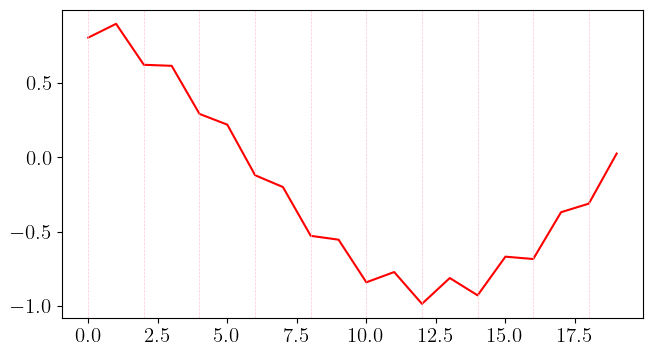

In [135]:

order_param = np.array([(-1)**(i) for i in np.arange(nn)])

plt.plot(np.arange(nn), order_param * expValues, color = 'red')
#plt.plot(np.arange(nn), expValues)


for i in np.arange(0, nn, 2):
    plt.axvline(x = i, color = 'pink', alpha = 0.9, lw = 0.5, ls ='--')

plt.show()

In [1]:
def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + J * Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - H1/N    
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2

    return H01, H11, H02, H3

Ns = [8, 10, 12]
omega = 20
w = omega
T = 2 * np.pi/omega
beta = float('inf')
nn = 20
J = 1
g = w/(4*(1- kick_duty)/2)
er = 0.2
h  = 0.8


for N in Ns:
    params = {'er':er, 'N':N,'J':J, 'g':g, 'maxT':n, 'h':h, 'nn':nn}

    H01, H11, H02, H3 = pbc_hamiltonian(params)
    V = (H01/N).full()
    k_eh =  H11.full()
    k_pi = H02.full()

    expValues = []
    # Use scipy.linalg.expm for proper matrix exponentiation to ensure unitarity

    U = expm(1j * k_pi) @ expm(1j * k_eh) @ expm(1j * V)
    psi = basis(2**N, 0).full()

    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, -(H3/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
        
    order_param = np.array([(-1)**(i) for i in np.arange(nn)])

    plt.plot(np.arange(nn), order_param * expValues, label=fr"$N-{N}$")
    #plt.plot(np.arange(nn), expValues)


for i in np.arange(0, nn, 2):
    plt.axvline(x = i, color = 'pink', alpha = 0.9, lw = 0.5, ls ='--')

plt.show()


NameError: name 'np' is not defined

Is U unitary?True 
Is U unitary? True


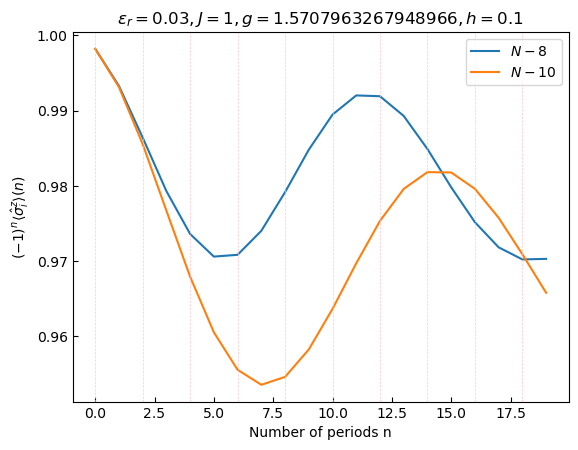

In [22]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - J * H1
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2

    return H01, H11, H02, H3

Ns = [8, 10]
nn = 20  # Time period upto which stroboscopic evolution is computed
J = 1
g = np.pi/2
er = 0.03
h  = 0.1

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H01, H11, H02, H3 = pbc_hamiltonian(args)
    V = (H01/ N).full()
    k_eh = H11.full()
    k_pi = H02.full()

    expValues = []
    # Use scipy.linalg.expm for proper matrix exponentiation to ensure unitarity

    U = expm(-1j * k_pi) @ expm(-1j * k_eh) @ expm(-1j * V)
    psi = basis(2**N, 0).full()

    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, -(H3/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues
    


params = [{'er':er, 'N':N,'J':J, 'g':g, 'maxT':nn, 'h':h, 'nn':nn} for N in Ns]

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, N in enumerate(Ns):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$N-{N}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
for i in np.arange(0, nn, 2):
    plt.axvline(x = i, color = 'pink', alpha = 0.9, lw = 0.5, ls ='--')


plt.xlabel('Number of periods n')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\epsilon_r={er}, J={J}, g={g}, h={h}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend()
plt.show()

Is U unitary? True
Is U unitary? True


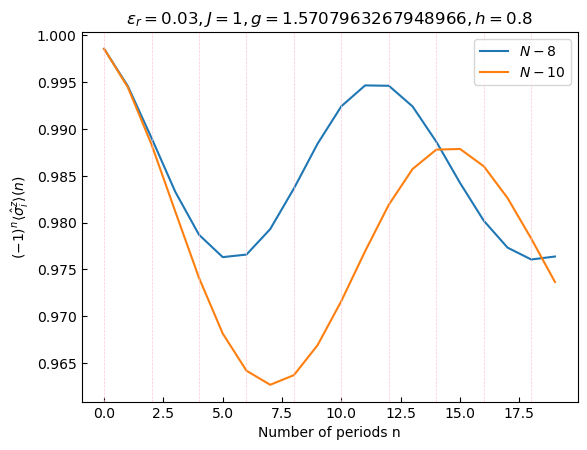

In [23]:
from ssl import Options
from scipy.special import jn_zeros
from itertools import combinations
import numpy as np
from qutip import *
from scipy import signal
import traceback
import tqdm
from multiprocessing import Pool
from scipy.linalg import expm
import matplotlib.pyplot as plt

def pbc_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    J = args['J']
    #beta = args['beta']
    g = args['g']
    h = args['h']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H1, H2, H3 = empt,  empt, empt
        
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sz, tensor(sz, id1))).full())        
    H1 = H1 + Qobj(tensor(sz, tensor(qeye(2**(N-2)), sz)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sx,id1)).full()) 
                
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H3 = H3 + Qobj(tensor(id,tensor(sz,id1)).full())

    H01 = - J * H1
    H11 = - Qobj(H2.full() * er + h * H3.full())
    H02 = - g * H2

    return H01, H11, H02, H3

Ns = [8, 10]
nn = 20  # Time period upto which stroboscopic evolution is computed
J = 1
g = np.pi/2
er = 0.03
h  = 0.8

def strobs_exps(args):
    N = args['N']
    nn = args['nn']    
    
    H01, H11, H02, H3 = pbc_hamiltonian(args)
    V = (H01/ N).full()
    k_eh = H11.full()
    k_pi = H02.full()

    expValues = []
    # Use scipy.linalg.expm for proper matrix exponentiation to ensure unitarity

    U = expm(-1j * k_pi) @ expm(-1j * k_eh) @ expm(-1j * V)
    psi = basis(2**N, 0).full()

    identity_check = U.conj().T @ U
    print("Is U unitary?", np.allclose(identity_check, np.eye(identity_check.shape[0])))

    for i in range(nn):
        psi = U @ psi  # apply unitary
        expValue = np.real(np.vdot(psi, -(H3/N).full() @ psi))  # expectation value
        expValues.append(expValue)
        
    return expValues
    


params = [{'er':er, 'N':N,'J':J, 'g':g, 'maxT':nn, 'h':h, 'nn':nn} for N in Ns]

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e10, num_cpus=1, openmp_threads=1)

data_strob = np.array(p.map(strobs_exps, params))
    
order_param = np.array([(-1)**(i) for i in np.arange(nn)])
for idx, N in enumerate(Ns):
    plt.plot(np.arange(nn), order_param * data_strob[idx], label=fr"$N-{N}$")
    #plt.plot(np.arange(nn), expValues)

#plt.ylim(-1.1,1.1)
for i in np.arange(0, nn, 2):
    plt.axvline(x = i, color = 'pink', alpha = 0.9, lw = 0.5, ls ='--')


plt.xlabel('Number of periods n')
plt.ylabel(r'$(-1)^n\langle \hat{\sigma}^z_i \rangle(n)$')
plt.title(fr"$\epsilon_r={er}, J={J}, g={g}, h={h}$", fontsize = 12)
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend()
plt.show()